### Bayesian linear model 
#### Copyright (C) 2020 Krzysztof Rusek AGH University of Science and Technology.

In [ ]:
'''
 *
 * Copyright (C) 2020 AGH University of Science and Technology.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at:
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 *
'''

In [3]:
import numpy as np
import seaborn as  sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_svi import svi

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Dataset

In [4]:
_x= np.random.normal(size=(20,1)).astype(np.float32)
_y= 4*_x+1 + np.random.normal(size=_x.shape, scale=.1).astype(np.float32)

# Baseline MLE model

In [5]:
mle_model=tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

mle_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

mle_model.fit(_x,_y, epochs=200,verbose=0)

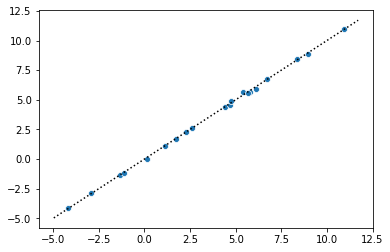

In [6]:
sns.scatterplot(mle_model.predict(_x).flatten(),_y.flatten())
plt.plot(plt.xlim(), plt.xlim(), 'k:')

# Bayesian model

Here we define a model

In [60]:
_model=tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
_model.build(_x.shape)



def _make_posterior(v):
    n = len(v.shape)
    print(v.name)
    return tfd.Independent(tfd.Normal(loc=tf.Variable(tf.convert_to_tensor(v)),
                                      scale=tfp.util.TransformedVariable(0.00002 + tf.zeros_like(v),
                                                                         tfb.Softplus()(tfb.Scale(0.2)))),
                           reinterpreted_batch_ndims=n,
                           name="posterior/"+v.name)


def _make_prior(posterior):
    n = len(posterior.event_shape)
    name = posterior.name
    name = 'prior/'+name
    print(name)
    if name.find('bias')>0:
        return tfd.Independent(tfd.Normal(tf.zeros(posterior.event_shape), 5.),
                               reinterpreted_batch_ndims=n,
                               name = name)
    else:
        return tfd.Independent(tfd.Normal(tf.zeros(posterior.event_shape), 2.),
                               reinterpreted_batch_ndims=n,
                               name = name)

## Inference

Here the model is made bayesian

In [61]:

bayesian_model = svi.SVI(_model,
                         kl_scale=1.0/_x.shape[0],
                         prior_fn=_make_prior,
                         posterior_fn=_make_posterior
                         )

bayesian_model.compile(
    loss=lambda y, rv_y: -rv_y.log_prob(y),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

h=bayesian_model.fit(_x,_y, epochs=1000, batch_size=20, verbose=0)

dense_10/kernel:0
dense_10/bias:0
prior/svi_9_posterior_dense_10_kernel_0
prior/svi_9_posterior_dense_10_bias_0


In [62]:
print("Posterior mean:", [float(x.numpy()) for x in bayesian_model.posterior.mean()])
print("Posterior std:", [float(x.numpy()) for x in bayesian_model.posterior.stddev()])

Posterior mean: [3.9404027462005615, 1.089030146598816]
Posterior std: [0.15930478274822235, 0.20152665674686432]


## Prediction

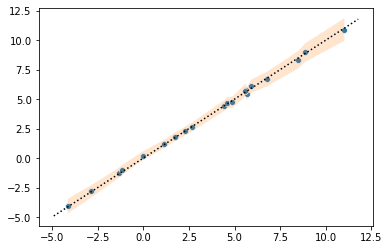

In [63]:
hats=[]
for i in range(100):
    yhat = bayesian_model(_x).mean().numpy()
    hats.append(yhat)

yhat = np.concatenate(hats, axis=1).mean(axis=1)
sd = np.concatenate(hats, axis=1).std(axis=1)
yf = _y.flatten()

sns.scatterplot(yf,yhat)
i = np.argsort(yf)
plt.fill_between(yf[i], yhat[i]-2*sd[i], yhat[i]+2*sd[i],alpha=0.2)
plt.plot(plt.xlim(),plt.xlim(),'k:')
plt.show()



## Out of distribution

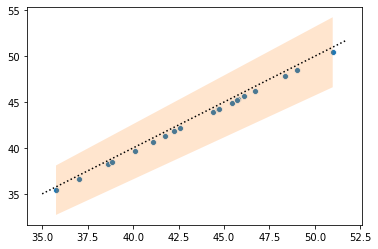

In [65]:
hats=[]

offset = 10.

for i in range(100):
    yhat = bayesian_model(_x+offset).mean().numpy()
    hats.append(yhat)

yhat = np.concatenate(hats, axis=1).mean(axis=1)
sd = np.concatenate(hats, axis=1).std(axis=1)
yf = (4*(_x+offset)+1).flatten()

sns.scatterplot(yf,yhat)
i = np.argsort(yf)
plt.fill_between(yf[i], yhat[i]-2*sd[i], yhat[i]+2*sd[i],alpha=0.2)
plt.plot(plt.xlim(),plt.xlim(),'k:')
plt.show()

